In [1]:
% matplotlib inline

import numpy as np
import pandas as pd
from math import *
import matplotlib.pyplot as plt
import scipy.io as sio
from mpl_toolkits.basemap import Basemap, cm
import gsw as sw
import scipy.stats as ss
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist, squareform

from scipy.interpolate import griddata


import seaborn as sns

from netCDF4 import Dataset

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Times New Roman'})

In [2]:
def SVh( P, h, bw ):
    '''
    Experimental semivariogram for a single lag
    '''
    pd = squareform( pdist( P[:,:2] ) )
    N = pd.shape[0]
    Z = list()
    for i in range(N):
        for j in range(i+1,N):
            if( pd[i,j] >= h-bw )and( pd[i,j] <= h+bw ):
                Z.append( ( P[i,2] - P[j,2] )**2.0 )
    return np.sum( Z ) / ( 2.0 * len( Z ) )
 
def SV( P, hs, bw ):
    '''
    Experimental variogram for a collection of lags
    '''
    sv = list()
    for h in hs:
        sv.append( SVh( P, h, bw ) )
    sv = [ [ hs[i], sv[i] ] for i in range( len( hs ) ) if sv[i] > 0 ]
    return np.array( sv ).T
 
def C( P, h, bw ):
    '''
    Calculate the sill
    '''
    c0 = np.var( P[:,2] )
    if h == 0:
        return c0
    return c0 - SVh( P, h, bw )

In [3]:
# import cruise data

in_file = '../data/KuroAlldata.csv'
data = pd.read_csv(in_file, sep = ',')

in_file = '../data/Kuroshio_Phytoplankton.csv'
phyto = pd.read_csv(in_file, sep = ',')

in_file = '../data/data_CHL.csv'
chl = pd.read_csv(in_file, sep = ',')

phyto['sample'] = phyto["STATION"] + '-' + phyto["BOTTLE"]

/Users/sclayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in double_scalars
/Users/sclayton/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


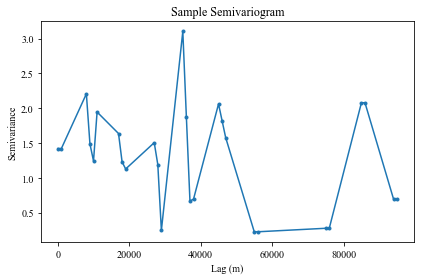

In [5]:
sub  = chl[chl['lon']==143.5]

# part of our data set recording porosity
P = np.array( sub[['x','depth (m)','CHL']] )
# bandwidth, plus or minus 250 meters
bw = 1000
# lags in 1000 meter increments from zero to 10,000
hs = np.arange(0,100000,bw)
sv = SV( P, hs, bw )
plt.plot( sv[0], sv[1], '.-' )
plt.xlabel('Lag (m)')
plt.ylabel('Semivariance')
plt.title('Sample Semivariogram') ;


/Users/sclayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in less


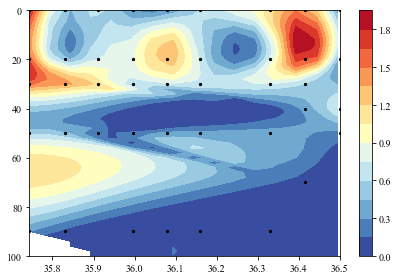

In [51]:

tlon = 144.5
sub  = chl[chl['lon']==tlon].dropna()

# define grid spacing
dx = 0.05
dy = 2
#define grid
xi = np.arange(sub['lat'].min(),sub['lat'].max()+dx,dx)
yi = np.arange(sub['depth (m)'].min(),sub['depth (m)'].max()+dy,dy)

# grid the data.
zi = griddata((sub['lat'], sub['depth (m)']), sub['CHL'], (xi[None,:], yi[:,None]), method='cubic')

zi[zi<0] = 0
# contour the gridded data, plotting dots at the randomly spaced data points.
# CS = plt.contour(xi,yi,zii,10,linewidths=1,colors='k')
CS = plt.contourf(xi,yi,zi,15, cmap=plt.cm.RdYlBu_r)
plt.colorbar() # draw colorbar
# plot data points.
plt.scatter(sub['lat'], sub['depth (m)'],marker='o',c='k',s=5)
plt.axis([sub['lat'].min(), sub['lat'].max(), sub['depth (m)'].min(), 100])
plt.gca().invert_yaxis()

plt.show()

In [46]:
sub['CHL'].max()

4.9015304895199998

In [52]:
chl.columns

Index([u'Unnamed: 0', u'station', u'lat', u'lon', u'bottle', u'depth (m)',
       u'fluorescence', u'dx', u'x', u'CHL', u'T(C)', u'theta', u'S',
       u'sigma_t', u'sample'],
      dtype='object')